# Deep learning Kaggle project: Facial Keypoints Detection


Le projet consiste à créer un modèle qui détecte différentes parties d'un visage. Pour ce, nous nous sommes tournés vers les CNN qui traitent généralement ce type de problèmes.

## Imports

In [ ]:
%matplotlib inline

In [2]:
%tensorflow_version 2

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time
from google.colab import drive
from google.colab import files
import random
from keras.applications.resnet50 import ResNet50
import imgaug as ia
import imgaug.augmenters as iaa

Using TensorFlow backend.


In [4]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
matplotlib 3.2.0
numpy 1.18.2
pandas 0.25.3
sklearn 0.22.2.post1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [ ]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

## Data Loading

In [6]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train = pd.read_csv('gdrive/My Drive/training.csv')  
test = pd.read_csv('gdrive/My Drive/test.csv')
lookid = pd.read_csv('gdrive/My Drive/IdLookupTable.csv')

In [8]:
train.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


*(Ce commentaire n'est plus d'actualité)* Ici, nous remarquons que nos données d'entraînement contiennent des valeurs manquantes que nous remplaçons en utilisant le *forward filling*.

In [ ]:
#train.isnull().any().value_counts()

In [ ]:
#train.fillna(method = 'ffill',inplace = True)

Nous décidons d'enlever les valeurs manquantes pour ne pas avoir d'approximation via la méthode de "*forward filling*". Conscients de la perte énorme d'information, nous comptons sur la **"Image Augmentation"** (voir plus loin) pour diversifier nos données d'entraînement.

In [ ]:
train=train.dropna()

Nous extractons les images du csv, qui y sont codées en pixels en 1 "channel" car il s'agit d'images en noir et blanc. Ces pixels étant séparés par des espaces, nous les recueillons plutôt dans des listes et ce pour chaque image.

In [ ]:
imag = []
for i in range(0,len(train['Image'])):
    img = train['Image'].iloc[i,].split(' ')
    img = [x for x in img]
    imag.append(img)

In [ ]:
image_list = np.array(imag,dtype = np.uint8)
X_train_full = image_list.reshape(-1,96,96,1)

In [14]:
X_train_full.shape

(2140, 96, 96, 1)

Puis les positions des différentes parties du visage qui nous intéressent sont recueillies à leur tour.

In [ ]:
training = train.drop('Image',axis = 1)

y_train_full = []
for i in range(0,len(train['Image'])):
    y = training.iloc[i,:]
    y_train_full.append(y)
    
y_train_full = np.array(y_train_full,dtype = np.uint8)

In [16]:
y_train_full.shape

(2140, 30)

Nous nous sommes rendus compte que la majorité des premières images du dataset sont de face et la majorité des dernières images sont de profil. Nous avons donc décidé de les mélanger avant de pouvoir créer le train set et le validation set par la suite. Pour ce, nous avons d'abord lié chaque image (*X_train_full*) avec ses keypoints (*y_train_full*) pour évidemment ne pas perdre la localisation des keypoints sur chaque image.

In [ ]:
Xy_train_full=[]
for i in range(len(X_train_full)):
  Xy_train_full.append([X_train_full[i],y_train_full[i]])

random.shuffle(Xy_train_full)


Ensuite, séparons ensuite le *X_train_full* et le *y_train_full* pour revenir à notre configuration de départ.

In [ ]:
X_train_full=[]
for i in range (len(Xy_train_full)):
  X_train_full.append(Xy_train_full[i][0])

X_train_full=np.array(X_train_full,dtype=np.uint8)

In [19]:
X_train_full.shape

(2140, 96, 96, 1)

In [ ]:
y_train_full=[]
for i in range (len(Xy_train_full)):
  y_train_full.append(Xy_train_full[i][1])

y_train_full=np.array(y_train_full,dtype=np.uint8)

In [21]:
y_train_full.shape

(2140, 30)

Les donneés sont ensuites séparées pour créer le train et le validation set.

In [ ]:
X_train = X_train_full[:-600]
y_train = y_train_full[:-600]
X_valid = X_train_full[-600:]
y_valid = y_train_full[-600:]

Ici, sachant que nous allons utiliser un modèle **ResNet** (voir plus loin), nous devons transformer les images en pixels de 3 "channels" (car c'est la taille d'inputs que ce réseau de neuronnes prend en entrée), et donc en *RGB*, tout en gardant évidemment leur couleur noir et blanc. Pour ce, il suffit de tripler la valeur de chaque pixel dans une liste qui correspondra à sa représentation en RGB.

In [ ]:
X_train=np.array([X_train[:,:,:,0],X_train[:,:,:,0],X_train[:,:,:,0]])
X_valid=np.array([X_valid[:,:,:,0],X_valid[:,:,:,0],X_valid[:,:,:,0]])

On décalle les dimensions de façon à avoir nos triplets RGB en "plus haute profondeur" comme c'était le cas pour les 1 "channel".

In [24]:
X_train=X_train.swapaxes(0,1)
print(X_train.shape)
X_train=X_train.swapaxes(1,2)
print(X_train.shape)
X_train=X_train.swapaxes(2,3)
print(X_train.shape)

(1540, 3, 96, 96)
(1540, 96, 3, 96)
(1540, 96, 96, 3)


In [25]:
X_valid=X_valid.swapaxes(0,1)
print(X_valid.shape)
X_valid=X_valid.swapaxes(1,2)
print(X_valid.shape)
X_valid=X_valid.swapaxes(2,3)
print(X_valid.shape)

(600, 3, 96, 96)
(600, 96, 3, 96)
(600, 96, 96, 3)


Enfin, il est toujours agréable (et utile) de jeter un coup d'oeil sur notre jeu de données.

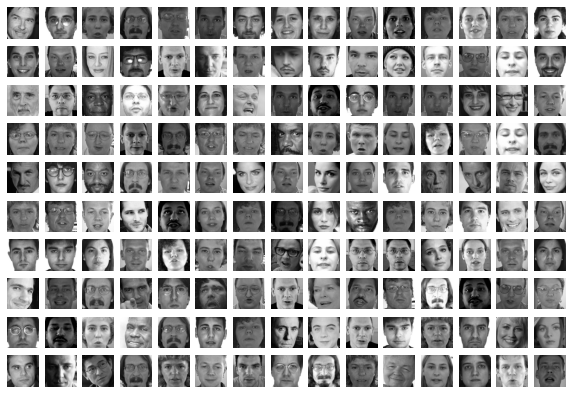

In [26]:
plt.figure(figsize=(10, 7))
n_rows, n_cols = 10, 15
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        plt.axis("off")
        plt.imshow(X_train[i],cmap='gray')

## Image Augmentation

In [ ]:
X_train_list = list(X_train)

In [ ]:
y_train_list = list(y_train)

Nous allons maintenant utiliser quelques techniques de **"Image Augmentation"** que nous avons jugés intéressants pour notre jeu de données.

### Brightness increase and decrease

Le code suivant a été repris de la documentation de la librairie *imgaug*, et bien sûr adapté à nos données.

In [ ]:
for i in range(len(X_train)):
  keypoints_list=[]
  for j in range(0,30,2):
    keypoints_list.append((y_train[i][j], y_train[i][j+1]))

  seq = iaa.Sequential([
      iaa.Multiply((0.5, 1.5)) # change brightness, doesn't affect keypoints
  ])

  # Augment keypoints and images.
  image_aug, kps_aug = seq(image=X_train[i], keypoints=keypoints_list)
  X_train_list.append(image_aug)
  kps_aug_list=[val for sublist in kps_aug for val in sublist]
  y_train_list.append(kps_aug_list)

Nous affichons la dernière image augmentée afin de vérifier que tout se passe bien. Nous le ferons à chaque type de "*Image Augmentation*" qu'on utilise.

Text(0.5, 1.0, 'Brightness increase or decrease')

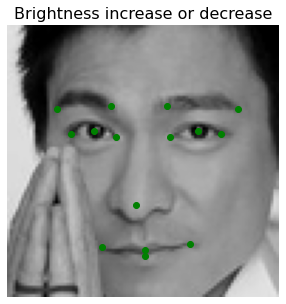

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.imshow(image_aug,cmap='gray')
for i in range(len(kps_aug)):
  plt.plot(kps_aug[i][0], kps_aug[i][1], 'o', color='green')
ax.axis('off')
ax.set_title('Brightness increase or decrease', size=16)

### Rotation to the left

In [ ]:
for i in range(len(X_train)):
  keypoints_list=[]
  for j in range(0,30,2):
    keypoints_list.append((y_train[i][j], y_train[i][j+1]))

  seq = iaa.Sequential([
      iaa.Affine(
          rotate=-10
      ) # rotate by exactly -10deg and scale to 50-70%, affects keypoints
  ])

  # Augment keypoints and images.
  image_aug, kps_aug = seq(image=X_train[i], keypoints=keypoints_list)
  X_train_list.append(image_aug)
  kps_aug_list=[val for sublist in kps_aug for val in sublist]
  y_train_list.append(kps_aug_list)

Text(0.5, 1.0, 'Rotation to the left')

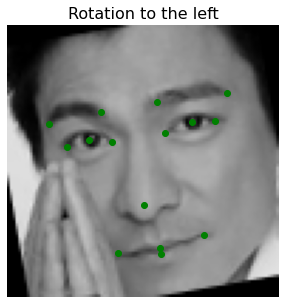

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.imshow(image_aug,cmap='gray')
for i in range(len(kps_aug)):
  plt.plot(kps_aug[i][0], kps_aug[i][1], 'o', color='green')
ax.axis('off')
ax.set_title('Rotation to the left', size=16)

### Rotation to the right

In [ ]:
for i in range(len(X_train)):
  keypoints_list=[]
  for j in range(0,30,2):
    keypoints_list.append((y_train[i][j], y_train[i][j+1]))

  seq = iaa.Sequential([
      iaa.Affine(
          rotate=10
      ) # rotate by exactly 10deg and scale to 50-70%, affects keypoints
  ])

  # Augment keypoints and images.
  image_aug, kps_aug = seq(image=X_train[i], keypoints=keypoints_list)
  X_train_list.append(image_aug)
  kps_aug_list=[val for sublist in kps_aug for val in sublist]
  y_train_list.append(kps_aug_list)

Text(0.5, 1.0, 'Rotation to the right')

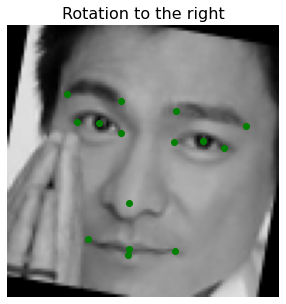

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.imshow(image_aug,cmap='gray')
for i in range(len(kps_aug)):
  plt.plot(kps_aug[i][0], kps_aug[i][1], 'o', color='green')
ax.axis('off')
ax.set_title('Rotation to the right', size=16)

### Translation

In [ ]:
for i in range(len(X_train)):
  keypoints_list=[]
  for j in range(0,30,2):
    keypoints_list.append((y_train[i][j], y_train[i][j+1]))

  seq = iaa.Sequential([
      iaa.Affine(
          translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -10 to +10 percent (per axis)
      )
  ])

  # Augment keypoints and images.
  image_aug, kps_aug = seq(image=X_train[i], keypoints=keypoints_list)
  X_train_list.append(image_aug)
  kps_aug_list=[val for sublist in kps_aug for val in sublist]
  y_train_list.append(kps_aug_list)

Text(0.5, 1.0, 'Translation')

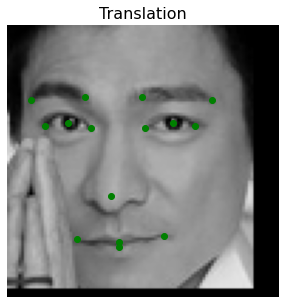

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.imshow(image_aug,cmap='gray')
for i in range(len(kps_aug)):
  plt.plot(kps_aug[i][0], kps_aug[i][1], 'o', color='green')
ax.axis('off')
ax.set_title('Translation', size=16)

### Scaling

In [ ]:
for i in range(len(X_train)):
  keypoints_list=[]
  for j in range(0,30,2):
    keypoints_list.append((y_train[i][j], y_train[i][j+1]))

  seq = iaa.Sequential([
      iaa.Affine(
          scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}# scale images to 80-120% of their size, individually per axis
      )
  ])

  # Augment keypoints and images.
  image_aug, kps_aug = seq(image=X_train[i], keypoints=keypoints_list)
  X_train_list.append(image_aug)
  kps_aug_list=[val for sublist in kps_aug for val in sublist]
  y_train_list.append(kps_aug_list)

Text(0.5, 1.0, 'Scaling')

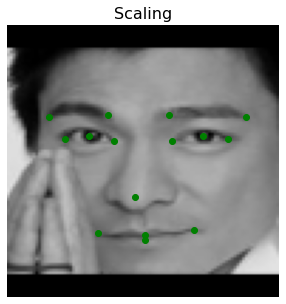

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.imshow(image_aug,cmap='gray')
for i in range(len(kps_aug)):
  plt.plot(kps_aug[i][0], kps_aug[i][1], 'o', color='green')
ax.axis('off')
ax.set_title('Scaling', size=16)

### Noise

In [ ]:
for i in range(len(X_train)):
  keypoints_list=[]
  for j in range(0,30,2):
    keypoints_list.append((y_train[i][j], y_train[i][j+1]))

  seq = iaa.Sequential([
      iaa.AdditiveGaussianNoise(scale=0.05*255) #Add gaussian noise to the image
  ])

  # Augment keypoints and images.
  image_aug, kps_aug = seq(image=X_train[i], keypoints=keypoints_list)
  X_train_list.append(image_aug)
  kps_aug_list=[val for sublist in kps_aug for val in sublist]
  y_train_list.append(kps_aug_list)

Text(0.5, 1.0, 'Noise')

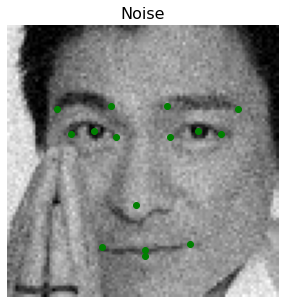

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.imshow(image_aug,cmap='gray')
for i in range(len(kps_aug)):
  plt.plot(kps_aug[i][0], kps_aug[i][1], 'o', color='green')
ax.axis('off')
ax.set_title('Noise', size=16)

### Horizontal flip

In [ ]:
for i in range(len(X_train)):
  keypoints_list=[]
  for j in range(0,30,2):
    keypoints_list.append((y_train[i][j], y_train[i][j+1]))

  seq = iaa.Sequential([
      iaa.Fliplr(0.5) # horizontally flip 50% of all images
  ])

  # Augment keypoints and images.
  image_aug, kps_aug = seq(image=X_train[i], keypoints=keypoints_list)
  X_train_list.append(image_aug)
  kps_aug_list=[val for sublist in kps_aug for val in sublist]
  y_train_list.append(kps_aug_list)

Text(0.5, 1.0, 'Horizontal flip')

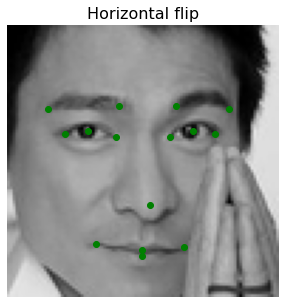

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.imshow(image_aug,cmap='gray')
for i in range(len(kps_aug)):
  plt.plot(kps_aug[i][0], kps_aug[i][1], 'o', color='green')
ax.axis('off')
ax.set_title('Horizontal flip', size=16)

Les données du jeu d'entraînement sont ensuite remises au type *array*.

In [ ]:
X_train=np.array(X_train_list,dtype=np.uint8)

In [44]:
X_train.shape

(12320, 96, 96, 3)

In [ ]:
y_train=np.array(y_train_list,dtype=np.uint8)

In [46]:
y_train.shape

(12320, 30)

## Convolutional neural network model

Avant de créer notre modèle, les données sont normalisées.

In [ ]:
X_train = X_train / 255

In [ ]:
y_train = y_train / 96

In [ ]:
X_valid = X_valid / 255

In [ ]:
y_valid = y_valid / 96

### Create the CNN

Nous avons choisi d'utiliser un réseau de neuronnes pré-entraîné **ResNet**, car comme vu en cours, il est souvent utilisé pour la classification avec localisation. Ici, nous avons choisi d'utiliser ResNet152V2, qui jusqu'à aujourd'hui est le modèle Resnet qui a montré les meilleurs résultats, tout en gardant à l'esprit que c'est un réseau de neuronnes plus complexe que les autres.

In [51]:
model = keras.applications.ResNet152V2(include_top=False, input_shape=(96,96,3), pooling='avg')
for layer in model.layers:
  layer.trainable=False
model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 50, 50, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

Nous ajoutons quelques couches pour faire du *fine-tuning* dont le rôle consitera à améliorer la prédiction des localisations. Cela dit, contrairement à ce qui a été vu en cours, nous n'ajoutons pas de couche *Class Probabilities* car dans cet exercice nous n'en avons pas besoin.

In [52]:
model_toAdd = keras.models.Sequential([
                                       
    keras.layers.Flatten(input_shape=(2048,)),
    keras.layers.Dense(512),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(256),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(128),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(96),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(48),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(30)

])
model_toAdd.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mae', 'acc'])
model_toAdd.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0

In [53]:
model1 = keras.models.Sequential([model, model_toAdd])
model1.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mae', 'acc'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 2048)              58331648  
_________________________________________________________________
sequential (Sequential)      (None, 30)                1235982   
Total params: 59,567,630
Trainable params: 1,233,902
Non-trainable params: 58,333,728
_________________________________________________________________


In [54]:
root_logdir = os.path.join(os.curdir, "my_logs")
logdir = os.path.join(root_logdir, "run_{}".format(time.time()))
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', mode='min', verbose=1, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath = "best_model.h5", monitor='val_mae', mode='min', verbose=1, save_best_only=True)
]

history = model1.fit(X_train, y_train, batch_size=128, epochs=100,
                    validation_data=(X_valid, y_valid), callbacks=callbacks)

Train on 12320 samples, validate on 600 samples
Epoch 1/100
12288/12320 [============================>.] - ETA: 0s - loss: 0.4385 - mae: 0.4831 - acc: 0.0622
Epoch 00001: val_mae improved from inf to 0.36148, saving model to best_model.h5
12320/12320 [==============================] - 82s 7ms/sample - loss: 0.4377 - mae: 0.4826 - acc: 0.0621 - val_loss: 0.1714 - val_mae: 0.3615 - val_acc: 0.0100
Epoch 2/100
12288/12320 [============================>.] - ETA: 0s - loss: 0.0926 - mae: 0.2370 - acc: 0.1353
Epoch 00002: val_mae improved from 0.36148 to 0.17227, saving model to best_model.h5
12320/12320 [==============================] - 64s 5ms/sample - loss: 0.0926 - mae: 0.2370 - acc: 0.1355 - val_loss: 0.0462 - val_mae: 0.1723 - val_acc: 0.1583
Epoch 3/100
12288/12320 [============================>.] - ETA: 0s - loss: 0.0546 - mae: 0.1806 - acc: 0.1723
Epoch 00003: val_mae improved from 0.17227 to 0.08958, saving model to best_model.h5
12320/12320 [==============================] - 65s 

In [ ]:
model1 = keras.models.load_model("best_model.h5")

### Training vs Validation plot

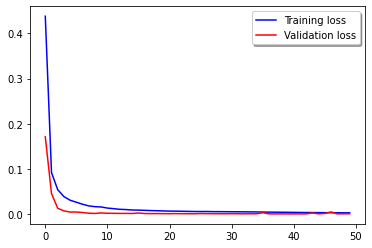

In [56]:
fig, ax = plt.subplots(1,1)
ax.plot(history.history['loss'], color='b', label="Training loss")
ax.plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax)
legend = ax.legend(loc='best', shadow=True)

La figure ci-dessus montre que nous ne sommes pas en présence d'*overfitting*, car notre modèle a bien appris de nos données d'entraînement, et n'est pas moins performant sur de nouvelles données (ici le "validation set"), d'où la position de la courbe représentant la training loss qui n'est pas en-dessous de celle de la validation loss. La figure montre plutôt que c'est un "good fit", car en plus les loss ne continuent pas à décroître et ceci est un bon signe. Cela dit, nous remarquons que l'accuracy est relativement basse, que ce soit sur le training ou le validation set. Ce modèle est donc loin d'être parfait et a besoin d'améliorations.

### Prediction

In [ ]:
def prediction_plot(x, y_real, y_pred):

    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    for ax in axes:
        ax.imshow(x[0, ..., 0], 'gray')
        ax.axis('off')
        
    points_real = np.vstack(np.split(y_real[0], 15)).T
    points_pred = np.vstack(np.split(y_pred[0], 15)).T
    axes[0].plot(points_pred[0], points_pred[1], 'o', color='red')
    axes[0].set_title('Predictions', size=16)
    axes[1].plot(points_real[0], points_real[1], 'o', color='green')
    axes[1].plot(points_pred[0], points_pred[1], 'o', color='red', alpha=0.5)
    axes[1].set_title('Real', size=16)

On remarque ci-dessous que les prédictions sont plutôt corrects (visuellement) malgré la faible accuracy du modèle.

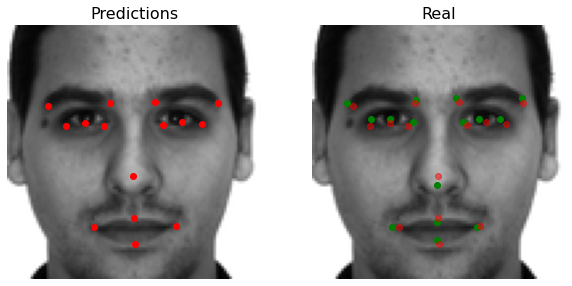

In [58]:
X_sample = X_valid[0,None]
y_sample = y_valid[0,None]
prediction = model1.predict(X_sample)
prediction_plot(X_sample*255, y_sample*96, prediction*96)

### Submission

In [ ]:
imag = []
for i in range(0,len(test['Image'])):
    img = test['Image'][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    imag.append(img)

In [ ]:
image_list = np.array(imag,dtype = np.uint8)
X_test_full = image_list.reshape(-1,96,96,1)

In [ ]:
X_test = X_test_full / 255

In [ ]:
X_test=np.array([X_test[:,:,:,0],X_test[:,:,:,0],X_test[:,:,:,0]])

In [63]:
X_test=X_test.swapaxes(0,1)
print(X_test.shape)
X_test=X_test.swapaxes(1,2)
print(X_test.shape)
X_test=X_test.swapaxes(2,3)
print(X_test.shape)

(1783, 3, 96, 96)
(1783, 96, 3, 96)
(1783, 96, 96, 3)


In [ ]:
results=model1.predict(X_test)*96

In [ ]:
lookid_list = list(lookid['FeatureName'])
imageID = list(lookid['ImageId']-1)
rowid = lookid['RowId']
rowid = list(rowid)

features = []
for feature in list(lookid['FeatureName']):
    features.append(lookid_list.index(feature))
    
locations = []
for x,y in zip(imageID,features):
    locations.append(results[x][y])

In [ ]:
rowid = pd.Series(rowid,name = 'RowId')
location = pd.Series(locations,name = 'Location')
submission = pd.concat([rowid,location],axis = 1)
submission.to_csv('submission_project.csv',index = False)

In [ ]:
files.download('submission_project.csv')